# EDSA Apple Prices Challenge

Regression_AM2_DSFT team is determined to help the Fresh Produce Industry to accurately determine how much stock to have on hand and what price to set the Golden Delicious Apples to.

In the Fresh Produce Industry, having the right amount of stock on hand is crucial. That's, not having too little that you run out of stock when customers want to buy more. And not having too much that food waste occurs. Yields from farms fluctuate by season. Should the prices then also fluctuate by season? The is a need for a more accurate method to determine how much stock to have on hand and what price to set the Golden Delicious Apples to.

Regression_AM2_DSFT will investigate key factors that have a great impact on the price of the Golden Delicious Apples to be maximised. We will construct a regression algorithm, capable of accurately predicting how much a kilogram of Golden Delicious Apples will cost, given certain parameters.

![Golden Apples](apples.png)


## Exploratory Data Analysis

### Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats

### Datasets

In [2]:
df_test = pd.read_csv("df-test_set.csv")
df_train = pd.read_csv("df-train_set.csv")

**Let's first take a look at our training data**

In [3]:
df_train.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
0,CAPE,EC120,1L,12.0,APPLE GRANNY SMITH,2020-03-10,108.0,112.0,3236.0,29,348.0,0,9.30
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
2,GAUTENG,AT200,1L,20.0,AVOCADO PINKERTON,2020-05-05,70.0,80.0,4860.0,66,1320.0,50,3.68
3,TRANSVAAL,BJ090,1L,9.0,TOMATOES-LONG LIFE,2020-01-20,60.0,60.0,600.0,10,90.0,0,6.67
4,WESTERN FREESTATE,PP100,1R,10.0,POTATO SIFRA (WASHED),2020-07-14,40.0,45.0,41530.0,927,9270.0,393,4.48


In [4]:
df_train.shape

(64376, 13)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64376 entries, 0 to 64375
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Province          64376 non-null  object 
 1   Container         64376 non-null  object 
 2   Size_Grade        64376 non-null  object 
 3   Weight_Kg         64376 non-null  float64
 4   Commodities       64376 non-null  object 
 5   Date              64376 non-null  object 
 6   Low_Price         64376 non-null  float64
 7   High_Price        64376 non-null  float64
 8   Sales_Total       64376 non-null  float64
 9   Total_Qty_Sold    64376 non-null  int64  
 10  Total_Kg_Sold     64376 non-null  float64
 11  Stock_On_Hand     64376 non-null  int64  
 12  avg_price_per_kg  64376 non-null  float64
dtypes: float64(6), int64(2), object(5)
memory usage: 6.4+ MB


In [6]:
# missing values
def total_missing(df):
    mis_val = df.isnull().sum()
    return mis_val

In [7]:
total_missing(df_train)

Province            0
Container           0
Size_Grade          0
Weight_Kg           0
Commodities         0
Date                0
Low_Price           0
High_Price          0
Sales_Total         0
Total_Qty_Sold      0
Total_Kg_Sold       0
Stock_On_Hand       0
avg_price_per_kg    0
dtype: int64

In [8]:
#Check for unique values(in Main df)
df_train.nunique()

Province               22
Container             153
Size_Grade             47
Weight_Kg              50
Commodities           270
Date                  147
Low_Price             320
High_Price            277
Sales_Total         18356
Total_Qty_Sold       3766
Total_Kg_Sold        8315
Stock_On_Hand        4192
avg_price_per_kg     3326
dtype: int64

In [9]:
df_train.describe()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
count,64376.000000,64376.000000,64376.000000,6.437600e+04,64376.000000,64376.000000,64376.000000,64376.00
mean,12.781592,75.651938,89.607858,1.939501e+04,446.104402,3336.641295,477.646328,NaN
std,35.943052,159.508144,172.223177,4.442192e+04,1184.169758,7682.295441,1453.892091,NaN
min,0.120000,1.000000,1.000000,-5.770000e+04,-595.000000,-5040.000000,-512.000000,-inf
25%,7.000000,30.000000,35.000000,1.154000e+03,20.000000,175.000000,0.000000,4.02
50%,10.000000,46.000000,55.000000,5.400000e+03,107.000000,940.000000,76.000000,6.00
75%,11.000000,80.000000,100.000000,1.877200e+04,390.000000,3250.000000,381.000000,8.67
max,500.000000,4400.000000,4400.000000,1.134701e+06,39453.000000,192230.000000,93193.000000,inf


By just looking at the above summary statistics, one can see that the values are not evenly distributed, we have very small values such as the minimum value of the variable `Low_Price` and big values such as the maximum of the variable `Stock_On_Hand`. This problem can have a negative impact on how well our model perform. Therefore, we will standardise our variables.

There's something wrong with our variable `avg_price_per_kg`, it has `infinity` values. The presence of `infinity` values in this variable is preventing us to compute summary statistics, as a result we don't know much about this variable. Let's go ahead and find out what is really going on

In [10]:
df_train[df_train['Total_Kg_Sold'] == 0]

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
1020,EASTERN FREESTATE,PP100,4M,10.0,POTATO (WASHED) MONDIAL,2020-05-04,5.0,5.0,-1080.0,0,0.0,0,-inf
9229,TRANSVAAL,AA010,1M,1.0,ONIONS MILD,2020-07-30,8.0,8.0,-25920.0,0,0.0,1840,-inf
21118,NATAL,IA400,2S,400.0,APPLE OTHER,2020-08-25,500.0,500.0,-500.0,0,0.0,0,-inf
25585,WESTERN CAPE - CERES,AF070,2M,7.0,ONIONS BROWN,2020-05-09,54.0,54.0,10780.0,0,0.0,0,inf
39119,TRANSVAAL,PD050,1,5.0,GRAPE OTHER BLACK,2020-01-09,50.0,50.0,-4800.0,0,0.0,0,-inf
40637,EASTERN FREESTATE,PP100,4M,10.0,POTATO (WASHED) MONDIAL,2020-02-21,5.0,5.0,-5060.0,0,0.0,0,-inf
46425,W.CAPE-BERGRIVER ETC,M4183,1S,18.3,APPLE GALA,2020-06-13,100.0,100.0,1820.0,0,0.0,0,inf
60891,CAPE,EC120,1L,12.0,APPLE BRAEBURN,2020-07-21,64.0,64.0,-1024.0,0,0.0,0,-inf


We have eight rows with infinity values. To get the values of avg_price_per_kg, we divide Sales_Total by Total_Kg_Sold. In mathematics, it is not allowed to divide any number by zero. All these rows have Total_Kg_Sold of zero. Therefore, it makes sense why their corresponding avg_price_per_kg variable contains infinity values.

So what are we going to do with this information, **we'll delete all the rows with infinity values**. Our data has 64376, hopefully deleting this 8 rows won't have a great impact on the performance of our model.

**EDA for only GOLDEN DELICIOUS APPLES**

In [11]:
df_train.columns

Index(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities',
       'Date', 'Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold',
       'Total_Kg_Sold', 'Stock_On_Hand', 'avg_price_per_kg'],
      dtype='object')

In [12]:
apple_df = df_train[df_train["Commodities"] == "APPLE GOLDEN DELICIOUS"]

In [13]:
apple_df.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
7,CAPE,JG110,2M,11.0,APPLE GOLDEN DELICIOUS,2020-04-14,50.0,50.0,16000.0,320,3520.0,0,4.55
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,APPLE GOLDEN DELICIOUS,2020-04-16,55.0,55.0,990.0,18,162.0,1506,6.11
40,CAPE,M4183,1S,18.3,APPLE GOLDEN DELICIOUS,2020-05-04,80.0,120.0,32020.0,388,7100.4,443,4.51
69,EASTERN CAPE,IA400,1S,400.0,APPLE GOLDEN DELICIOUS,2020-09-28,1800.0,1800.0,1800.0,1,400.0,2,4.50


In [14]:
#apple dataframe with oultiers
apple_df.shape

(1952, 13)

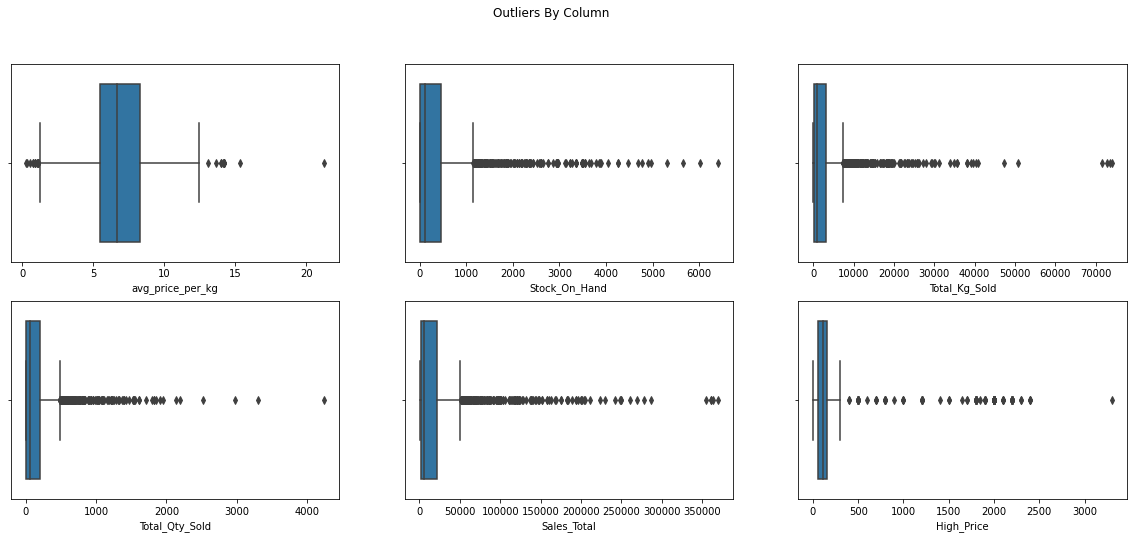

In [15]:
fig, axes = plt.subplots(2, 3,  sharey=True, figsize=(20, 8))
fig.suptitle('Outliers By Column')

sns.boxplot(ax=axes[0, 0], data=apple_df, x='avg_price_per_kg')
sns.boxplot(ax=axes[0, 1], data=apple_df, x='Stock_On_Hand')
sns.boxplot(ax=axes[0, 2], data=apple_df, x='Total_Kg_Sold')
sns.boxplot(ax=axes[1, 0], data=apple_df, x='Total_Qty_Sold')
sns.boxplot(ax=axes[1, 1], data=apple_df, x='Sales_Total')
sns.boxplot(ax=axes[1, 2], data=apple_df, x='High_Price')

In [16]:
#Check for missing values
apple_df.isnull().sum()

Province            0
Container           0
Size_Grade          0
Weight_Kg           0
Commodities         0
Date                0
Low_Price           0
High_Price          0
Sales_Total         0
Total_Qty_Sold      0
Total_Kg_Sold       0
Stock_On_Hand       0
avg_price_per_kg    0
dtype: int64

In [17]:
#Check for unique values
apple_df.nunique()

Province               7
Container             11
Size_Grade            10
Weight_Kg              9
Commodities            1
Date                 147
Low_Price             94
High_Price            88
Sales_Total         1324
Total_Qty_Sold       505
Total_Kg_Sold        850
Stock_On_Hand        735
avg_price_per_kg     601
dtype: int64

In [18]:
apple_df.describe()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000
mean,40.460912,174.307377,215.648053,20053.533811,174.510758,2960.176332,408.393955,6.778893
std,99.655169,373.553578,433.546159,39005.069445,308.810797,6097.416527,724.450582,2.248744
min,3.000000,2.000000,5.000000,5.000000,1.000000,3.000000,0.000000,0.250000
25%,9.000000,50.000000,60.000000,1325.000000,12.000000,219.600000,9.000000,5.460000
50%,12.000000,80.000000,108.000000,5495.000000,64.000000,853.500000,126.500000,6.670000
75%,18.300000,127.250000,160.000000,21082.500000,200.000000,3093.525000,468.000000,8.280000
max,400.000000,2300.000000,3300.000000,369464.000000,4237.000000,74000.000000,6400.000000,21.240000


In [19]:
#Data correlation
apple_df.corr()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
Weight_Kg,1.000000,0.863182,0.905852,0.180518,-0.133317,0.294117,-0.144105,-0.337886
Low_Price,0.863182,1.000000,0.938140,0.183230,-0.122823,0.269744,-0.127677,-0.141740
High_Price,0.905852,0.938140,1.000000,0.265672,-0.096456,0.372282,-0.094174,-0.164496
Sales_Total,0.180518,0.183230,0.265672,1.000000,0.771865,0.962338,0.284693,0.108473
Total_Qty_Sold,-0.133317,-0.122823,-0.096456,0.771865,1.000000,0.651440,0.390168,0.087536
Total_Kg_Sold,0.294117,0.269744,0.372282,0.962338,0.651440,1.000000,0.229062,-0.001007
Stock_On_Hand,-0.144105,-0.127677,-0.094174,0.284693,0.390168,0.229062,1.000000,0.105028
avg_price_per_kg,-0.337886,-0.141740,-0.164496,0.108473,0.087536,-0.001007,0.105028,1.000000


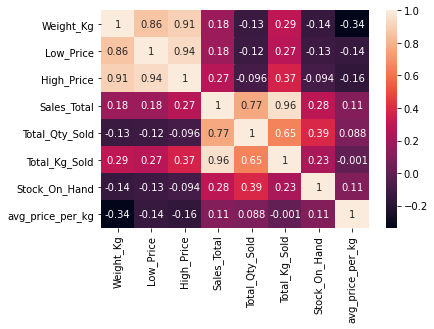

In [20]:
sns.heatmap(apple_df.corr(), xticklabels=apple_df.corr(), yticklabels=apple_df.corr(), annot=True)

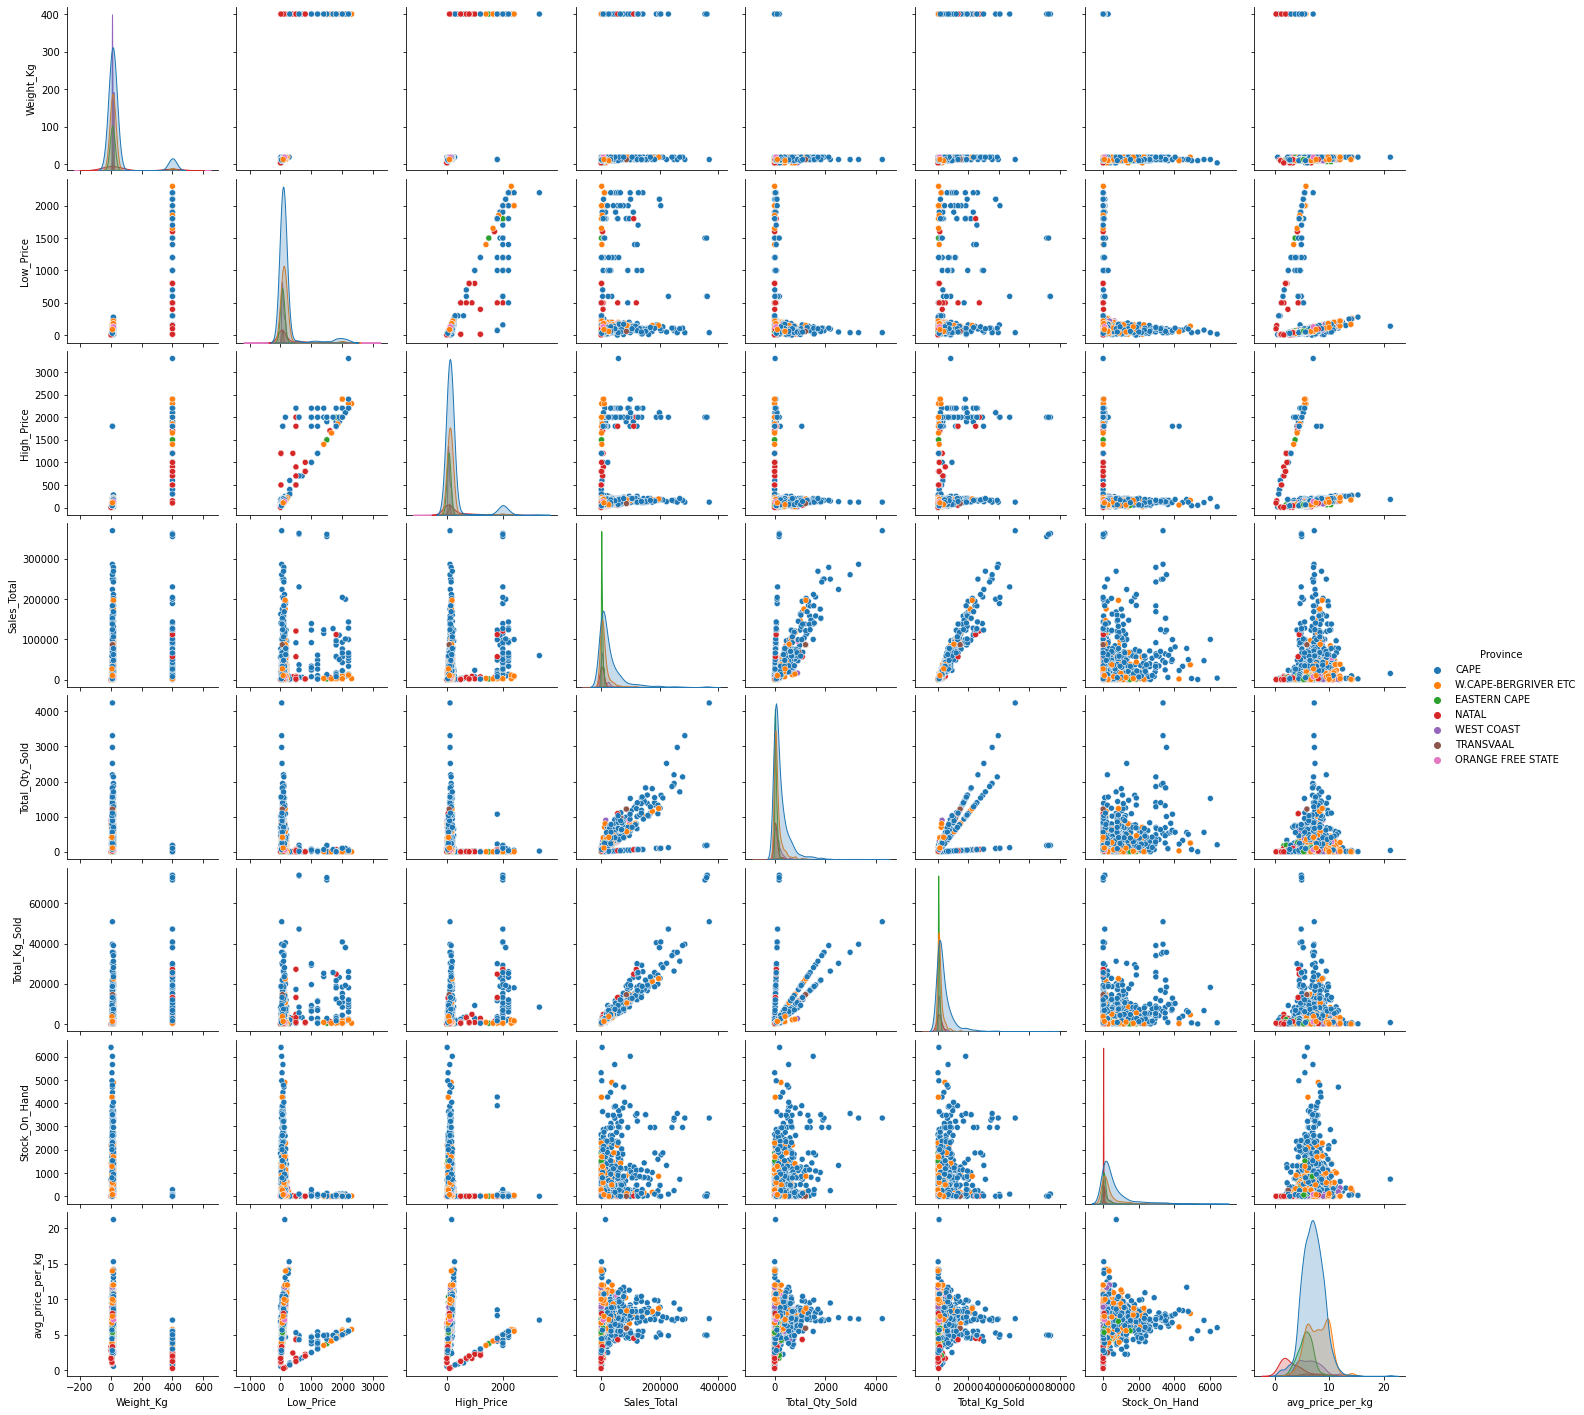

In [21]:
#Analysis of data relationships

sns.pairplot(apple_df, hue='Province')

In [22]:
apple_df.columns

Index(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities',
       'Date', 'Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold',
       'Total_Kg_Sold', 'Stock_On_Hand', 'avg_price_per_kg'],
      dtype='object')

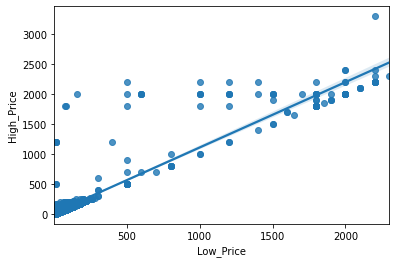

In [23]:
sns.regplot(x='Low_Price', y='High_Price', data = apple_df)

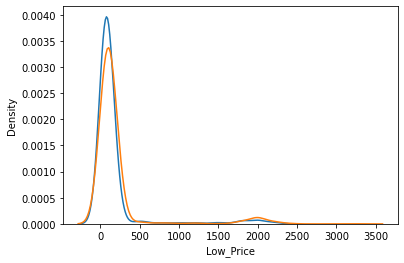

In [24]:
sns.kdeplot(apple_df['Low_Price'])
sns.kdeplot(apple_df['High_Price'])

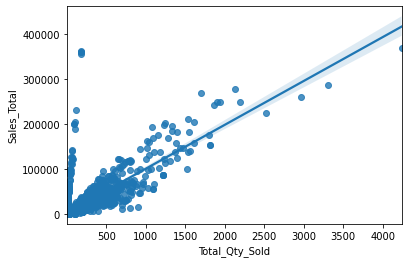

In [25]:
sns.regplot(x='Total_Qty_Sold', y='Sales_Total', data = apple_df)

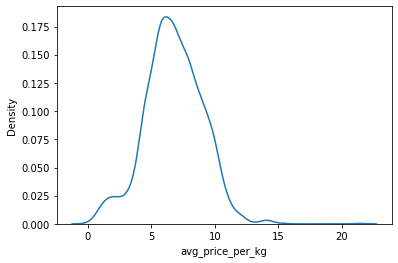

In [26]:
sns.kdeplot(apple_df['avg_price_per_kg'])

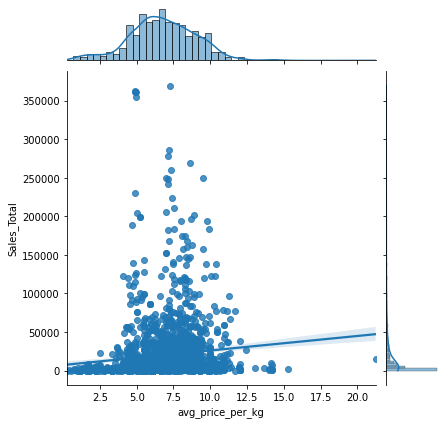

In [27]:
sns.jointplot(x="avg_price_per_kg", y="Sales_Total", data=apple_df, kind="reg")

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

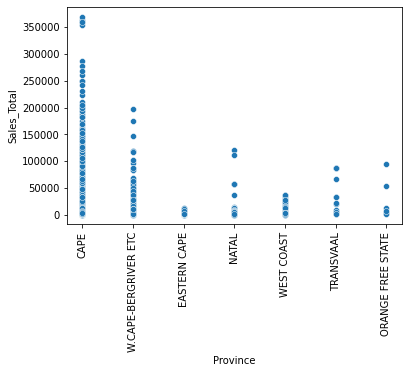

In [49]:
sns.scatterplot(data=apple_df, x="Province", y="Sales_Total")
plt.xticks(rotation=90)

(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000.]),
 <a list of 10 Text major ticklabel objects>)

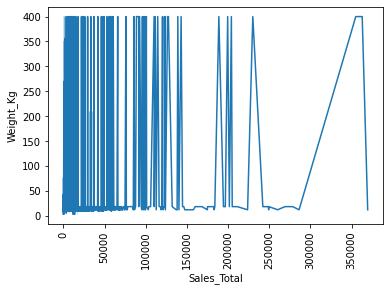

In [56]:
sns.lineplot(data=apple_df, x="Sales_Total", y="Weight_Kg")
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

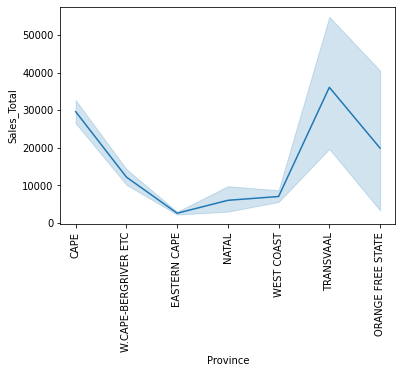

In [59]:
sns.lineplot(data=apple_df, x="Province", y="Sales_Total")
plt.xticks(rotation=90)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


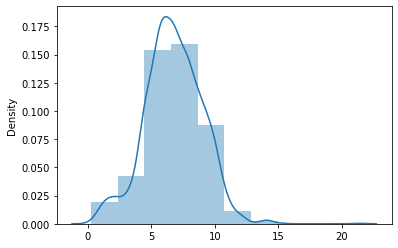

In [74]:
sns.distplot(x = apple_df['avg_price_per_kg'], bins = 10)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

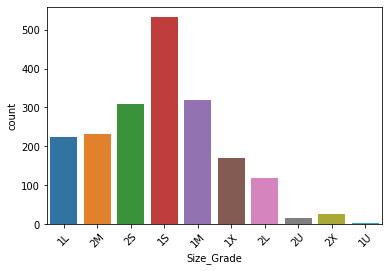

In [89]:
sns.countplot(apple_df['Size_Grade'])
plt.xticks(rotation=45)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

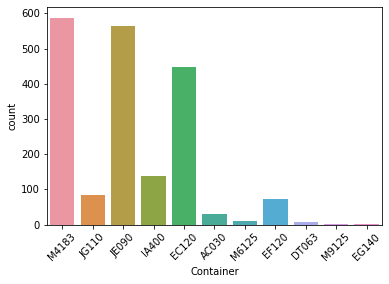

In [90]:
sns.countplot(apple_df['Container'])
plt.xticks(rotation=45)

In [70]:
apple_df.columns

Index(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities',
       'Date', 'Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold',
       'Total_Kg_Sold', 'Stock_On_Hand', 'avg_price_per_kg'],
      dtype='object')

#### Test Data

In [28]:
df_test.head(2)

,Index,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand
0,1,W.CAPE-BERGRIVER ETC,EC120,1M,12.0,APPLE GOLDEN DELICIOUS,2020-07-09,128.0,136.0,5008.0,38,456.0,0
1,2,W.CAPE-BERGRIVER ETC,M4183,1X,18.3,APPLE GOLDEN DELICIOUS,2020-01-20,220.0,220.0,1760.0,8,146.4,2


In [29]:
df_test = df_test.drop(columns = ['Index'])
df_test.head(2)

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand
0,W.CAPE-BERGRIVER ETC,EC120,1M,12.0,APPLE GOLDEN DELICIOUS,2020-07-09,128.0,136.0,5008.0,38,456.0,0
1,W.CAPE-BERGRIVER ETC,M4183,1X,18.3,APPLE GOLDEN DELICIOUS,2020-01-20,220.0,220.0,1760.0,8,146.4,2


In [30]:
df_test.shape

(685, 12)

In [31]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685 entries, 0 to 684
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province        685 non-null    object 
 1   Container       685 non-null    object 
 2   Size_Grade      685 non-null    object 
 3   Weight_Kg       685 non-null    float64
 4   Commodities     685 non-null    object 
 5   Date            685 non-null    object 
 6   Low_Price       685 non-null    float64
 7   High_Price      685 non-null    float64
 8   Sales_Total     685 non-null    float64
 9   Total_Qty_Sold  685 non-null    int64  
 10  Total_Kg_Sold   685 non-null    float64
 11  Stock_On_Hand   685 non-null    int64  
dtypes: float64(5), int64(2), object(5)
memory usage: 64.3+ KB


In [32]:
df_test.columns

Index(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities',
       'Date', 'Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold',
       'Total_Kg_Sold', 'Stock_On_Hand'],
      dtype='object')

In [33]:
df_test.describe()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand
count,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000
mean,34.142482,164.202891,195.590073,18788.111212,174.883212,2725.402336,439.245255
std,87.575995,355.167319,389.109476,33951.586813,299.351142,5059.123311,715.985761
min,3.000000,10.000000,10.000000,10.000000,1.000000,6.300000,0.000000
25%,9.000000,50.000000,64.000000,1300.000000,13.000000,204.000000,20.000000
50%,12.000000,80.000000,112.000000,5520.000000,62.000000,860.100000,153.000000
75%,18.300000,128.000000,160.000000,21176.000000,200.000000,3033.000000,516.000000
max,400.000000,2400.000000,2400.000000,308010.000000,2774.000000,47200.000000,6827.000000


In [34]:
df_train.corr()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
Weight_Kg,1.000000,0.832214,0.846184,0.007710,-0.055573,0.032639,-0.039879,-0.054991
Low_Price,0.832214,1.000000,0.962504,-0.006438,-0.093333,-0.031281,-0.062260,0.124585
High_Price,0.846184,0.962504,1.000000,0.029433,-0.082580,-0.000889,-0.046742,0.123440
Sales_Total,0.007710,-0.006438,0.029433,1.000000,0.750116,0.920337,0.265030,-0.000303
Total_Qty_Sold,-0.055573,-0.093333,-0.082580,0.750116,1.000000,0.735714,0.347718,-0.037589
Total_Kg_Sold,0.032639,-0.031281,-0.000889,0.920337,0.735714,1.000000,0.236541,-0.077350
Stock_On_Hand,-0.039879,-0.062260,-0.046742,0.265030,0.347718,0.236541,1.000000,-0.025811
avg_price_per_kg,-0.054991,0.124585,0.123440,-0.000303,-0.037589,-0.077350,-0.025811,1.000000


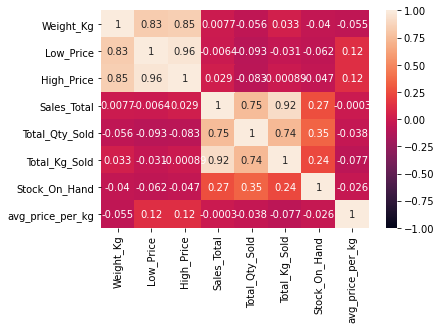

In [35]:
sns.heatmap(df_train.corr(), vmin = -1, vmax = 1, annot = True)

In [36]:
#A + 8

## Data Cleaning and Formatting
Before we do anything, we first have to clean our data. Our data contains negative values that don't make sense, i.e. a negative weight doesn't exist. We'll go now convert all the negative values into positive values.

In [37]:
df_train[['Sales_Total','Total_Qty_Sold','Total_Kg_Sold','Stock_On_Hand', 'avg_price_per_kg']] = df_train[['Sales_Total','Total_Qty_Sold','Total_Kg_Sold','Stock_On_Hand', 'avg_price_per_kg']].abs()

Now we'll go ahead and remove all the rows with infinity values

In [38]:
df_train = df_train[df_train['Total_Kg_Sold'] != 0]

In [39]:
#df_train.replace([np.inf, -np.inf], np.nan)
df_train.describe()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
count,64368.000000,64368.000000,64368.000000,6.436800e+04,64368.000000,64368.000000,64368.000000,64368.000000
mean,12.775983,75.649130,89.606784,1.940680e+04,446.300071,3338.179897,477.911602,10.470263
std,35.912807,159.508488,172.225175,4.441990e+04,1184.180060,7682.194481,1453.886928,26.124673
min,0.120000,1.000000,1.000000,5.000000e+00,1.000000,0.120000,0.000000,0.010000
25%,7.000000,30.000000,35.000000,1.160000e+03,20.000000,175.000000,0.000000,4.020000
50%,10.000000,46.000000,55.000000,5.400000e+03,107.000000,940.000000,77.000000,6.000000
75%,11.000000,80.000000,100.000000,1.877700e+04,390.000000,3257.400000,381.000000,8.670000
max,500.000000,4400.000000,4400.000000,1.134701e+06,39453.000000,192230.000000,93193.000000,1250.000000


In [40]:
#def float_to_int(x):
#    if x == float('inf') or x == float('-inf'):
#        return 999 # or a large value you choose

In [41]:
#c = [b[i].astype(float) for i in range(len(df_train))]
#df_train['avg_price_per_kg'] = pd.DataFrame(c)

In [42]:
# Seasons Generating Function
def season(x, date_format):
    date_str = [str(i) for i in x]
    months = [datetime.strptime(i, date_format).month for i in date_str]
    
    dict_ = {1: 'Summer',
             2: 'Summer',
             3: 'Autumn',
             4: 'Autumn',
             5: 'Autumn',
             6: 'Winter',
             7: 'Winter',
             8: 'Winter',
             9: 'Spring',
             10: 'Spring',
             11: 'Spring',
             12: 'Summer'}
    
    seasons = [dict_[month] for month in months] 
    
    return seasons

In [43]:
df_test['Season'] = pd.DataFrame(season(df_test.Date, '%d/%m/%Y'))
df_test.head(2)

ValueError: ignored

Since we don't need the date column anymore, we can drop it

In [ ]:
df_test = df_test.drop(columns = ['Date'])

In [ ]:
df_train['Season'] = pd.DataFrame(season(df_train.Date, '%Y-%m-%d'))
df_train.head(2)

Let's drop the date column

In [ ]:
df_train = df_train.drop(columns = ['Date'])

In [ ]:
#plt.boxplot(df_train['avg_price_per_kg'], hue = 'Season')

## Feature Engineering

### Dummy Variables

In [ ]:
df_train2 = df_train[['Weight_Kg', 'Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold', 'Total_Kg_Sold', 'Stock_On_Hand', 'avg_price_per_kg']]

In [ ]:
df_train = pd.get_dummies(df_train)
df_train.head()

In [ ]:
df_train2 = pd.get_dummies(df_train2)
df_train2.head()

### Data Scaling
The units of our data are not fit to be used for comparing different variables, this makes it hard for us to study the relationship between different variables. As result, we will scale our data to so that our module is impacted by the relationship between different variables, `NOT` by the units of measurement of the variables. We will use **Z-score standardisation** to scale our data. Z-score standardisation robust to outlier values. 

Let's go ahead an apply standard scaling to our model. We'll import the StandardScalar() object from sklearn.preprocessing

In [ ]:
# Import scaler method from sklearn
from sklearn.preprocessing import StandardScaler

In [ ]:
# Split data into predictors and response
X = df_train.drop('avg_price_per_kg', axis=1)
y = df_train['avg_price_per_kg']

X2 = df_train2.drop('avg_price_per_kg', axis=1)
y2 = df_train2['avg_price_per_kg']

In [ ]:
# Create scaler object
scaler = StandardScaler()

In [ ]:
# Create scaled version of the predictors (there is no need to scale the response)
X_scaled = scaler.fit_transform(X)
X_scaled2 = scaler.fit_transform(X2)

In [ ]:
# Convert the scaled predictor values into a dataframe
X_standardise = pd.DataFrame(X_scaled,columns=X.columns)
X_standardise2 = pd.DataFrame(X_scaled2,columns=X2.columns)
X_standardise2.head()

## Ridge Regression
### Preprocessing
We will first split our data into a training and a testing set. Let's go ahead and import neccessary libraries

In [ ]:
# Import train/test splitting function from sklearn
from sklearn.model_selection import train_test_split

In [ ]:
# Import the ridge regression module from sklearn
from sklearn.linear_model import Ridge

In [ ]:
# Import metrics module
from sklearn import metrics

In [ ]:
# Split the data into train and test, being sure to use the standardised predictors
X_train, X_test, y_train, y_test = train_test_split(X_standardise, y, test_size=0.2, shuffle=False)

In [ ]:
# Create ridge model
ridge = Ridge()

In [ ]:
# Train the model
ridge.fit(X_train, y_train)

In [ ]:
# Extract the model intercept value
b0 = float(ridge.intercept_)

In [ ]:
# Extract the model coefficient value
coeff = pd.DataFrame(ridge.coef_, X.columns, columns=['Coefficient'])

In [ ]:
print("Intercept:", float(b0))

In [ ]:
# Check out the coefficients
coeff

### Assess the predictive accuracy of the model

In [ ]:
# Check training accuracy
train_ridge = ridge.predict(X_train)

print('Ridge Training RMSE: ', np.sqrt(metrics.mean_squared_error(y_train, train_ridge)))
print('Ridge Training R-Squared: ', metrics.r2_score(y_train, train_ridge))

In [ ]:
# Check testing accuracy
test_ridge = ridge.predict(X_test)

print('Ridge Testing RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, test_ridge)))
print('Ridge Testing R-Squared: ', metrics.r2_score(y_test, test_ridge))

## LASSO Regression
### Preprocessing
We'll be using the same dataset and train/test split as in previous regression trains.

In [ ]:
# Import LASSO module
from sklearn.linear_model import Lasso

In [ ]:
# Split the data into train and test, being sure to use the standardised predictors
X_train, X_test, y_train, y_test = train_test_split(X_standardise, y, test_size=0.2, shuffle=False)

In [ ]:
# Create LASSO model object, setting alpha to 0.01
lasso = Lasso(alpha=0.1)

In [ ]:
# Train the LASSO model
lasso.fit(X_train, y_train)

In [ ]:
# Extract intercept from model
intercept = float(lasso.intercept_)

In [ ]:
# Extract coefficient from model
coeff = pd.DataFrame(lasso.coef_, X.columns, columns=['Coefficient'])

In [ ]:
# Extract intercept
print("Intercept:", float(intercept))

In [ ]:
excl =coeff[coeff.Coefficient == 0]
excl[:50]

In [ ]:
excl[50:100]

In [ ]:
excl[100:]

### Assess the predictive accuracy of the model

In [ ]:
# Check training accuracy
train_lasso = lasso.predict(X_train)

print('Ridge Training RMSE: ', np.sqrt(metrics.mean_squared_error(y_train, train_lasso)))
print('Ridge Training R-Squared: ', metrics.r2_score(y_train, train_lasso))

In [ ]:
# Check testing accuracy
test_lasso = lasso.predict(X_test)

print('Ridge Testing RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, test_lasso)))
print('Ridge Testing R-Squared: ', metrics.r2_score(y_test, test_lasso))